### Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 13 13:36:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Import Libraries

In [ ]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

from IPython.display import clear_output

In [ ]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [ ]:
print("tensorflow version: {}".format(tf. __version__))

tensorflow version: 2.8.2


### Load Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_root = '/gdrive/My Drive/Cityscapes'

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

In [ ]:
!pip install cityscapesscripts
clear_output()

In [ ]:
from cityscapesscripts.download import downloader

session = downloader.login()
downloader.get_available_packages(session=session)

print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

Cityscapes username or email address: eric.julianto@zettabyte.life
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y



In [ ]:
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg
clear_output()

In [ ]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [ ]:
# process anr archive image in smaller size
IMG_SHAPE = 299, 299

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

make_archive('gtFine', 'zip', GT_DIR)
make_archive('leftImg', 'zip', IMG_DIR)

'/content/leftImg.zip'

In [ ]:
# normalize image pixels
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

In [ ]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

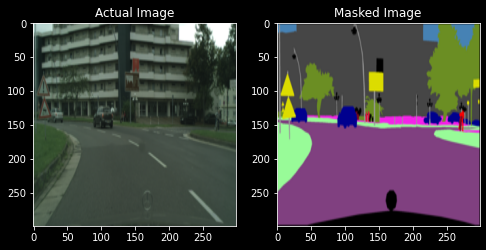

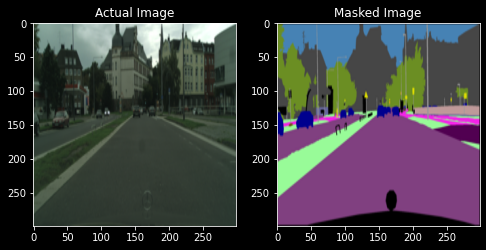

In [ ]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion

    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X

    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
               padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[16,16,32],'1')
    # block_2
    base = conv_block(base,[16,16,32],'2')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,32))(red)
    red = Conv2D(filters=32,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=128,interpolation='bilinear',name='red_upsampling')(red)
    red = tf.image.resize(red, [IMG_SIZE, IMG_SIZE])
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=32,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    yellow = tf.image.resize(yellow, [IMG_SIZE, IMG_SIZE])
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=32,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    blue = tf.image.resize(blue, [IMG_SIZE, IMG_SIZE])
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=32,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    green = tf.image.resize(green, [IMG_SIZE, IMG_SIZE])
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    return X

In [ ]:
input_shape = list(im_train_ds.take(1))[0].shape
input_layer = tf.keras.Input(shape=input_shape, name='input')
output_layer = last_conv_module(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_1_a (Conv2D)             (None, 299, 299, 16  64          ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block_1_batch_norm_a (BatchNor  (None, 299, 299, 16  64         ['block_1_a[0][0]']              
 malization)                    )                                                             

In [ ]:
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.zip((im_test_ds, gt_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
checkpoint_path = drive_root+'pspnet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model.compile(optimizer='adam', loss='mse', metrics='accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=100, 
                    callbacks=[cp_callback, es_callback])
model.save(drive_root + 'pspnet_trained.h5')

Epoch 1/100
93/93 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.6425
Epoch 1: saving model to /gdrive/My Drive/Cityscapespspnet/cp.ckpt
93/93 [==============================] - 118s 1s/step - loss: 0.0525 - accuracy: 0.6425 - val_loss: 0.0809 - val_accuracy: 0.6709
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.6111
Epoch 2: saving model to /gdrive/My Drive/Cityscapespspnet/cp.ckpt
93/93 [==============================] - 111s 1s/step - loss: 0.0458 - accuracy: 0.6111 - val_loss: 0.0610 - val_accuracy: 0.6814
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.5936
Epoch 3: saving model to /gdrive/My Drive/Cityscapespspnet/cp.ckpt
93/93 [==============================] - 111s 1s/step - loss: 0.0418 - accuracy: 0.5936 - val_loss: 0.0493 - val_accuracy: 0.5785
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.5723
Epoch 4: saving model to /gdr

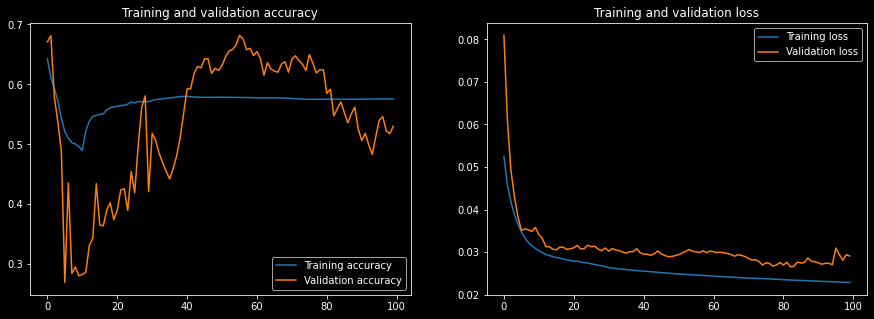

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

In [ ]:
loss, acc = model.evaluate(test_ds)
print('Test Data Accuracy: ', acc)

48/48 [==============================] - 16s 329ms/step - loss: 0.1910 - accuracy: 0.3714
Test Data Accuracy:  0.3714490830898285


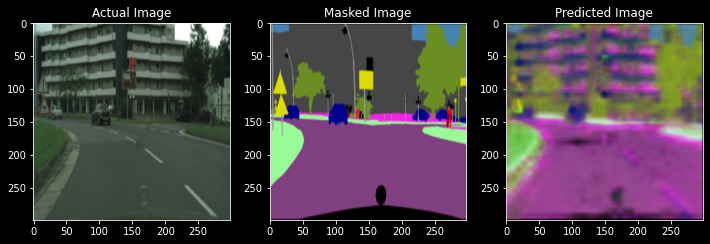

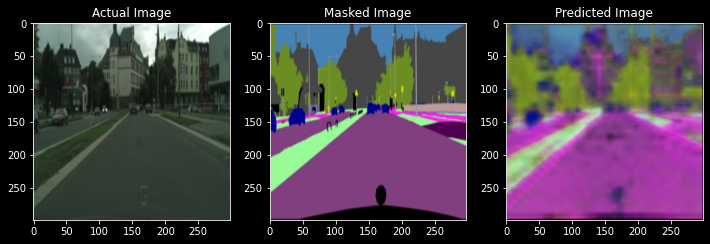

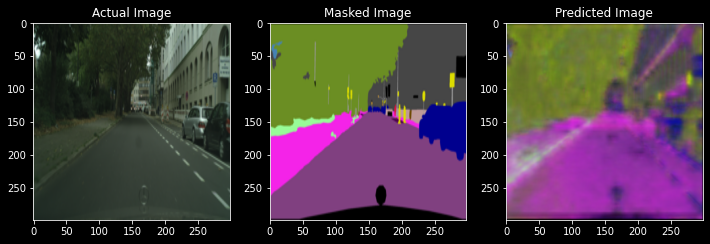

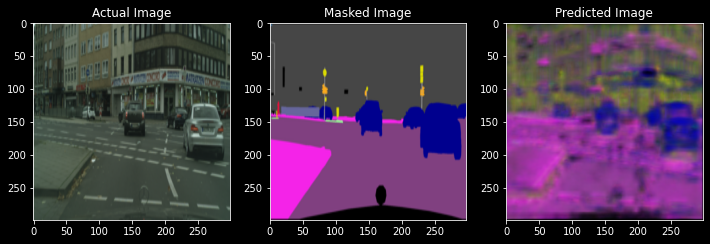

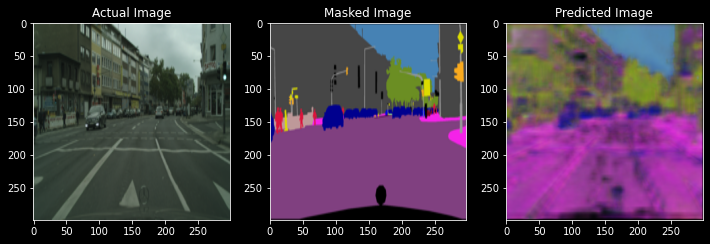

In [ ]:
pred_test_ds = model.predict(train_ds)

for img, gt, pred in list(zip(im_train_ds.take(5), gt_train_ds.take(5), pred_test_ds)):
    visualize_images(img, gt, pred)

---